In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize

sns.set()
%matplotlib inline

In [3]:
path = 'stock_sample.csv'
data = pd.read_csv(path, index_col = ['DATE'], parse_dates = ['DATE'])
data.head(10)

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO\
DATE,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.2300,47.3700,248000,38.517220,39.606614,38.450681,39.398849,248000,NaN,0.0,1.0\
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.1400,46.4800,131300,38.617027,38.691882,38.375826,38.658613,131300,NaN,0.0,1.0\
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.1600,46.4100,184900,37.743715,38.708516,37.560735,38.600392,184900,NaN,0.0,1.0\
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.8700,18.8700,10000,18.860000,18.910000,18.870000,18.870000,10000,NaN,0.0,1.0\
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.7900,18.8100,39095,18.860000,18.890000,18.790000,18.810000,39095,NaN,0.0,1.0\
2018-06-01,GF,BBG000C3C6S2,EOD,daily,18.58,18.7600,18.5800,18.7400,17468,18.580000,18.760000,18.580000,18.740000,17468,NaN,0.0,1.0\
2018-05-31,GF,BBG000C3C6S2,EOD,daily,18.52,18.5200,18.3012,18.4900,22384,18.520000,18.520000,18.301200,18.490000,22384,NaN,0.0,1.0\
2018-05-30,GF,BBG000C3C6S2,EOD,daily,18.47,18.6780,18.4700,18.6500,22633,18.470000,18.678000,18.470000,18.650000,22633,NaN,0.0,1.0\
2018-05-29,GF,BBG000C3C6S2,EOD,daily,18.51,18.5100,18.1500,18.2562,67412,18.510000,18.510000,18.150000,18.256200,67412,NaN,0.0,1.0\


### Data Cleansing

In [4]:
data = data[data.TICKER != 'GEF']
data = data[data.TYPE != 'Intraday']

drop_Cols = ['FIGI', 'TYPE', 'FREQUENCY', 'ADJ_OPEN', 'ADJ_HIGH', 'ADJ_LOW', 'ADJ_CLOSE', 'ADJ_VOLUME', 'ADJ_FACTOR', 'EX_DIVIDEND', 'SPLIT_RATIO\\']

data = data.drop(drop_Cols, axis = 1)

data.head()

,TICKER,OPEN,HIGH,LOW,CLOSE,VOLUME
DATE,,,,,,
2018-06-04,GF,18.86,18.890,18.7900,18.8100,39095
2018-06-01,GF,18.58,18.760,18.5800,18.7400,17468
2018-05-31,GF,18.52,18.520,18.3012,18.4900,22384
2018-05-30,GF,18.47,18.678,18.4700,18.6500,22633
2018-05-29,GF,18.51,18.510,18.1500,18.2562,67412


### Plot Stock Price (2014 ~ 2018)

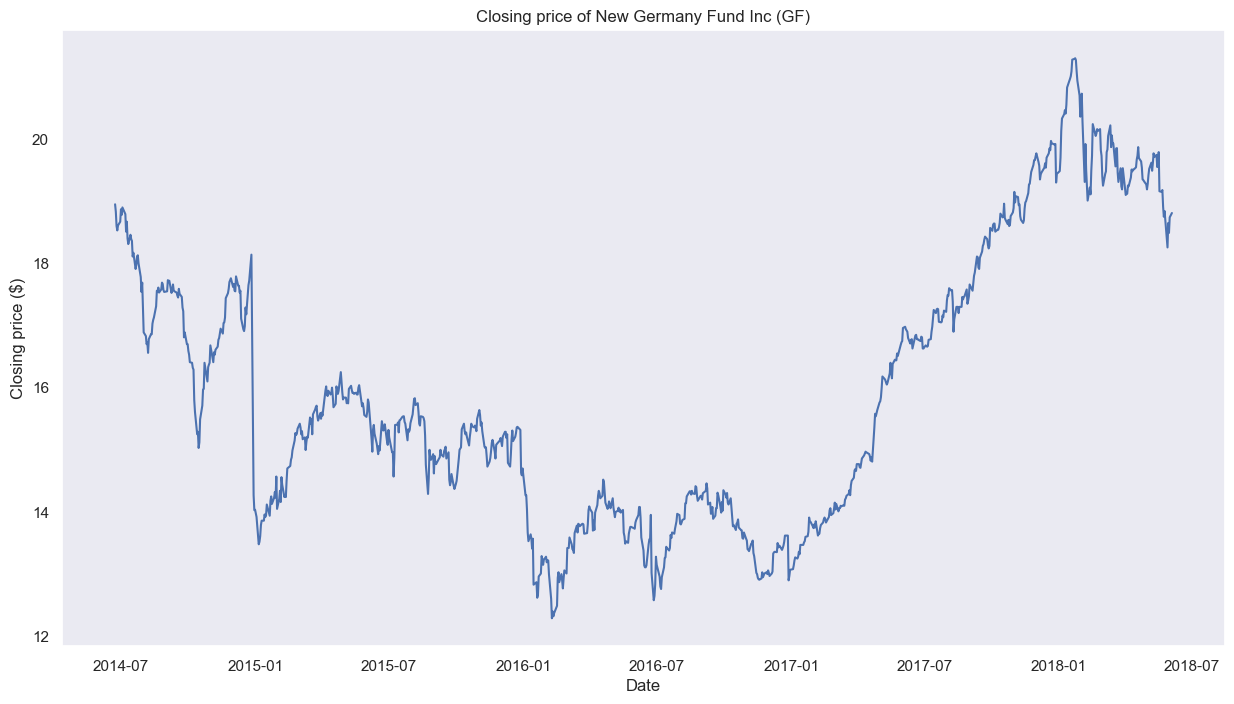

In [5]:
plt.figure(figsize = (15, 8))
plt.plot(data.CLOSE)
plt.title('Closing price of New Germany Fund Inc (GF)')
plt.xlabel('Date')
plt.ylabel('Closing price ($)')
plt.grid(False)
plt.show()

### Moving Average

In [6]:
def plot_moving_average(series, window, plot_interval = False, scale = 1.96):
    try:
        if not isinstance(series, pd.Series):
            raise TypeError('\'series\' must be a Pandas Series')
    except TypeError as e:
        print('Error: ', e)
        return None

    try:
        if not isinstance(window, int):
            raise TypeError('\'window\' must be an Integer')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    try:
        if not isinstance(plot_interval, bool):
            raise TypeError('\'plot_interval\' must be a Boolean')
    except TypeError as e:
        print('Error: ', e)
        return None

    rolling_mean = series.rolling(window = window).mean()

    plt.figure(figsize = (15, 8))
    plt.title(f'Moving average\nwindow size = {window}')
    plt.plot(rolling_mean, 'g', label = 'Rolling mean trend')

    if plot_interval:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        low_bound = rolling_mean - (mae + scale * deviation)
        up_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(up_bound, 'r--', label = 'Upper/Lower bounds')
        plt.plot(low_bound, 'r--')

    plt.plot(series[window:], label = 'Actual value')
    plt.legend(loc = 'best')

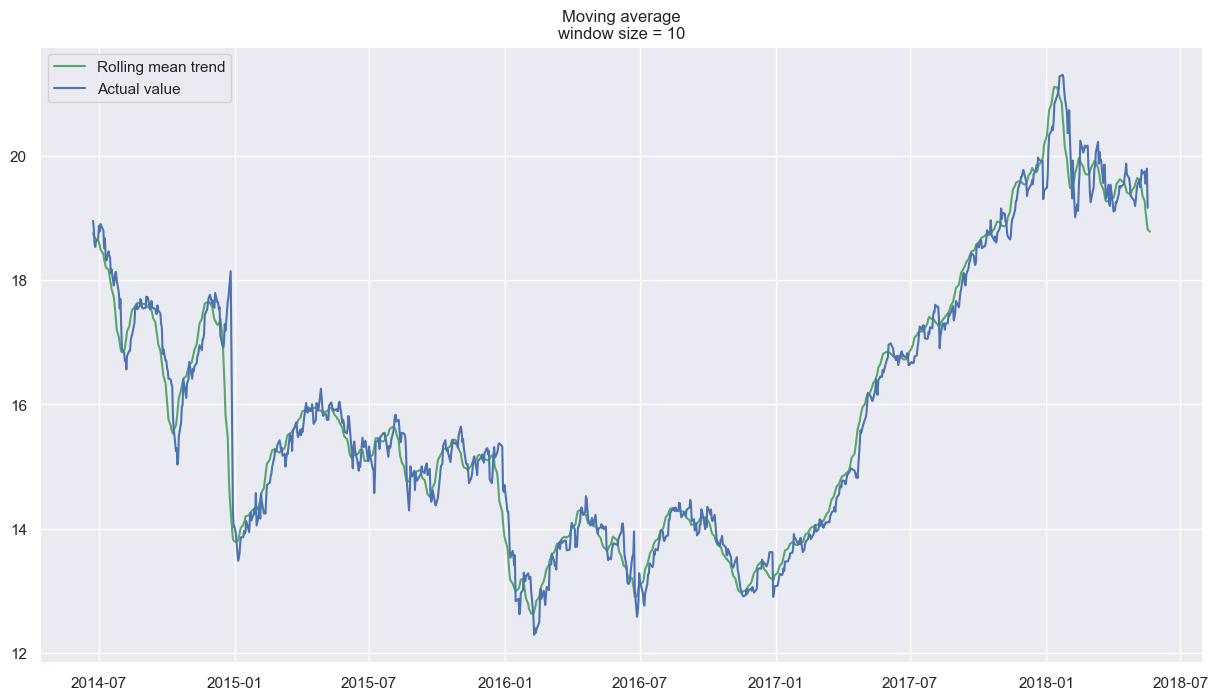

In [8]:
# 10-day moving average
plot_moving_average(data.CLOSE, 10)

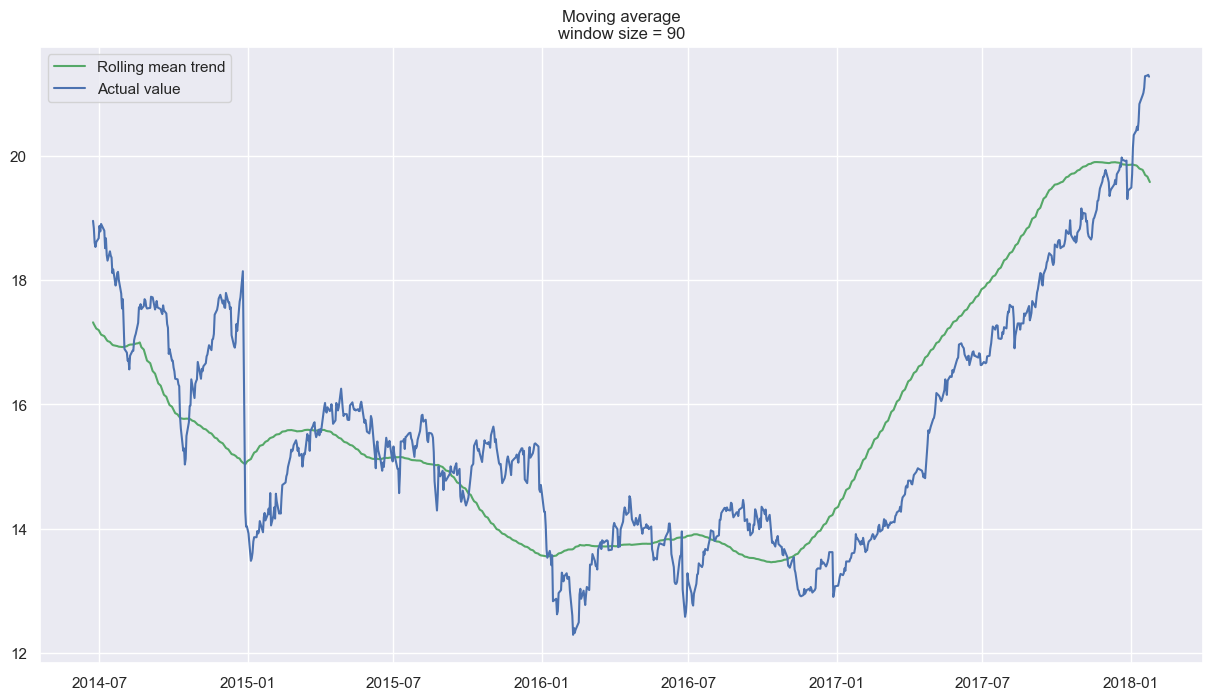

In [10]:
# 90-day moving average
plot_moving_average(data.CLOSE, 90)

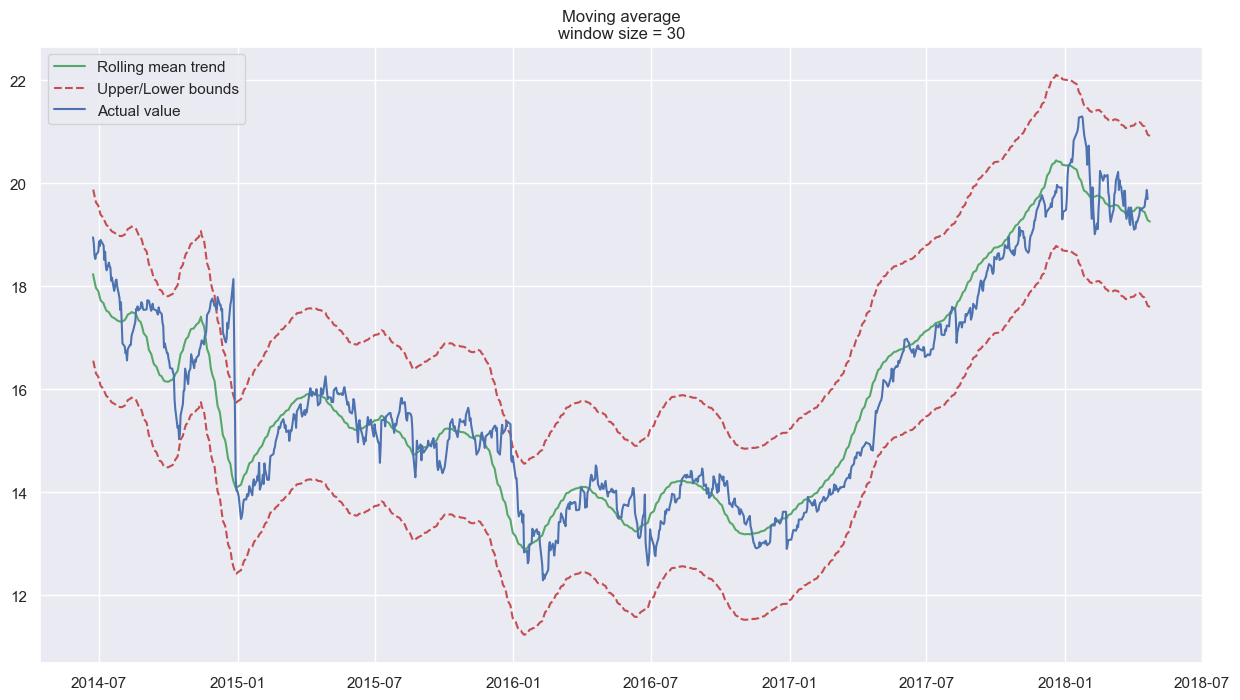

In [9]:
# 30-day moving average with deviation intervals
plot_moving_average(data.CLOSE, 30, True)

### Exponential Smoothing
$y = \alpha x_{t} + (1 - \alpha) y_{t-1} , \ where \ t > 0$

In [42]:
def expo_smoothing(series, alpha):
    try:
        if not isinstance(alpha, float):
            raise TypeError('\'alpha\' must be a Float')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    if alpha <= 0 or alpha >= 1:
        raise Exception('\'alpha\' must be in the range of 0 to 1')

    result = [series[0]]
    for i in range(1, len(series)):
        result.append(alpha * series[i] + (1 - alpha) * result[i - 1])
    return result

def plot_expo_smoothing(series, alphas):
    try:
        if not isinstance(series, pd.Series):
            raise TypeError('\'series\' must be a Pandas Series')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    try:
        if not isinstance(alphas, list):
            raise TypeError('\'alphas\' must be a List')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    plt.figure(figsize = (15, 8))
    plt.title('Exponential Smoothing')
    for alpha in alphas:
        plt.plot(expo_smoothing(series, alpha), label = f'Alpha = {alpha}')
    plt.plot(series.values, 'c', label = 'Actual')
    plt.legend(loc = 'best')
    plt.axis('tight')
    plt.grid(True)

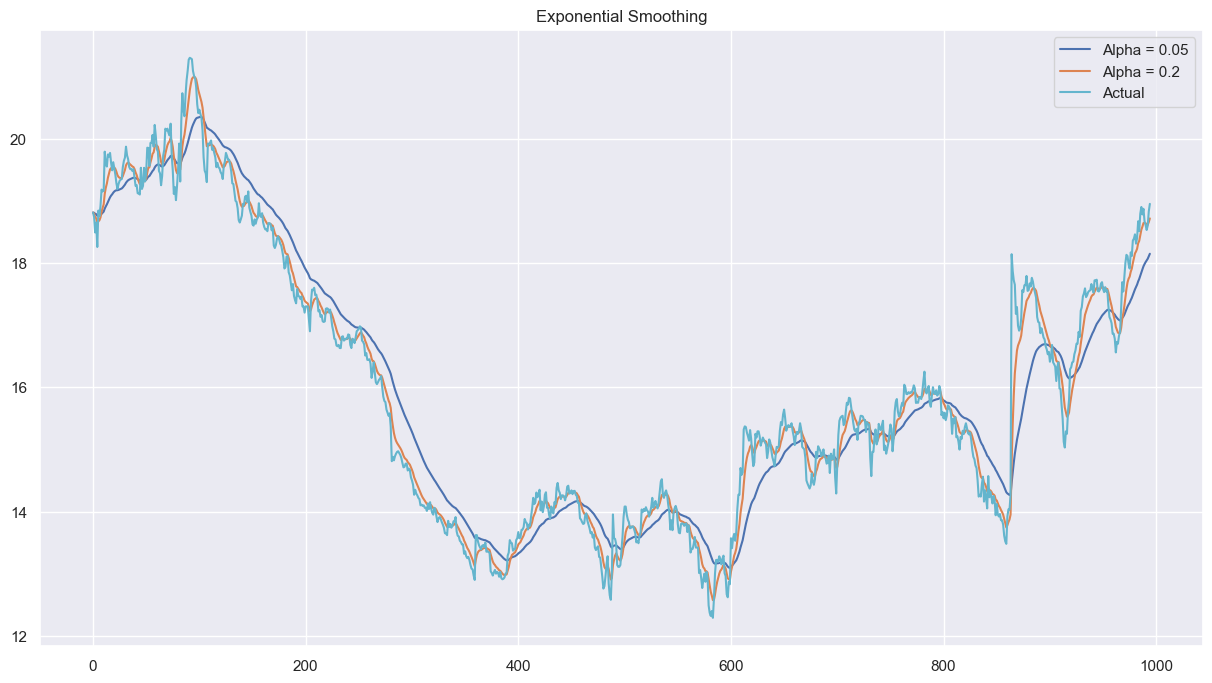

In [45]:
# plot exponential smoothing
plot_expo_smoothing(data.CLOSE, [0.05, 0.2])

### Double Exponential Smoothing
$y = \alpha x_{t} + (1 - \alpha) (y_{t-1} + b_{t-1})$ <br>
$b_{t} = \beta (y_{t} - y_{t-1}) + (1 - \beta) b_{t-1}$

In [48]:
def double_expo_smoothing(series, alpha, beta):
    try:
        if not isinstance(alpha, float):
            raise TypeError('\'alpha\' must be a Float')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    try:
        if not isinstance(beta, float):
            raise TypeError('\'beta\' must be a Float')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    if alpha <= 0 or alpha >= 1:
        raise Exception('\'alpha\' must be in the range of 0 to 1')
    if beta <= 0 or beta >= 1:
        raise Exception('\'beta\' must be in the range of 0 to 1')

    result = [series[0]]
    for i in range(1, len(series) + 1):
        if i == 1:
            y, b = series[0], series[1] - series[0]
        if i >= len(series):
            x = result[-1]
        else:
            x = series[i]
        
        y_last, y = y, alpha * x + (1 - alpha) * (y + b)
        b = beta * (y - y_last) + (1 - beta) * b
        result.append(y + b)
    
    return result

def plot_double_expo_smoothing(series, alphas, betas):
    try:
        if not isinstance(series, pd.Series):
            raise TypeError('\'series\' must be a Pandas Series')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    try:
        if not isinstance(alphas, list):
            raise TypeError('\'alphas\' must be a List')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    try:
        if not isinstance(betas, list):
            raise TypeError('\'betas\' must be a List')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    plt.figure(figsize = (15, 8))
    plt.title('Double Exponential Smoothing')
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_expo_smoothing(series, alpha, beta), label = f'Alpha = {alpha}, Beta = {beta}')
    plt.plot(series.values, 'c', label = 'Actual')
    plt.legend(loc = 'best')
    plt.axis('tight')
    plt.grid(True)

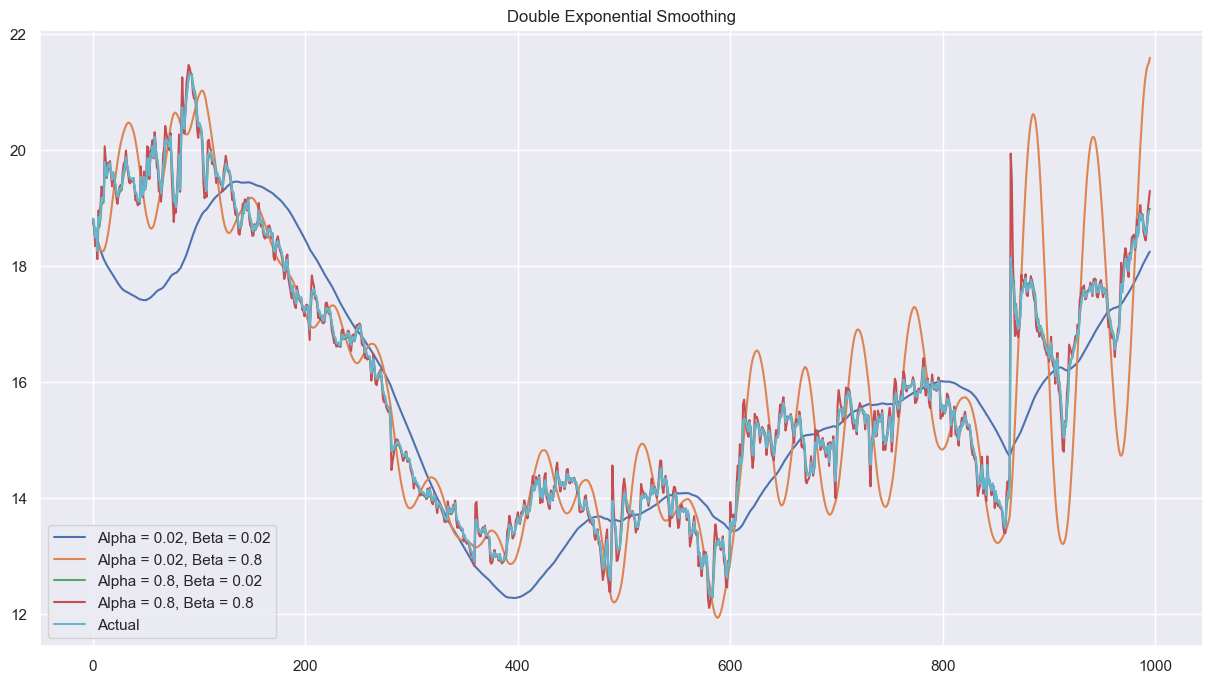

In [62]:
plot_double_expo_smoothing(data.CLOSE, alphas = [0.02, 0.8], betas = [0.02, 0.8])

### Modeling